# Waveguide crossing based on cosine tapers

To achieve a high integration density on a photonic chip, efficient routing of light with low loss using compact junctions is necessary. Therefore, waveguide crossings are crucial building blocks in high performance integrated circuits. 

This example model demonstrates the simulation of a waveguide crossing based on cosine tapers. The convex cosine taper focuses the guided mode at the center of the crossing junction. This ensures the light is efficiently transmitted into the through port instead of scattered into the cross ports. The device achieves an insertion loss of ~0.2 dB and crosstalk ~-30 dB in the O-band (1260 nm -1360 nm). The design is adapted from [Sujith Chandran, et al. "Beam shaping for ultra-compact waveguide crossings on monolithic silicon photonics platform," Opt. Lett. 45, 6230-6233 (2020)](https://opg.optica.org/ol/abstract.cfm?uri=ol-45-22-6230).

<img src="img/waveguide_crossing.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from scipy.optimize import fsolve


## Simulation Setup

Define geometric parameters and materials. In this device, the Si waveguide has a thickness of 161 nm and a width of 350 nm. 

In [2]:
h = 0.161  # waveguide thickness
w_in = 0.35  # input taper width
w_out = 1.1  # output taper width
w_m = 0.75  # amplitude of the cos function
l_t = 5.3  # taper length
inf_eff = (
    1000  # effective infinity used to make sure the waveguides extend into the pml
)


In [3]:
si = td.Medium(permittivity=3.67**2)
sio2 = td.Medium(permittivity=1.45**2)


The taper width is described by a cosine function $w(x)=w_m cos(ax+b)$. To determine the parameters $a$ and $b$, we solve a system of equations to ensure $w(x)=w_{in}/2$ at the beginning of the taper and $w(x)=w_{out}/2$ at the end of the taper. This can be easily done using fsolve from Scipy.

After we obtain $w(x)$, vertices can be generated and the taper can be made using PolySlab. Once the first taper is made, the rest three tapers can be made by manipulating the vertices with the symmetry relation.

In [4]:
# numerically solve for the cos function that describes the taper shape
def equations(x0):
    a, b = x0
    return (
        w_m * np.cos(a * (-w_out / 2) + b) - w_out / 2,
        w_m * np.cos(a * (-w_out / 2 - l_t) + b) - w_in / 2,
    )


a, b = fsolve(equations, (0.5, 2))

x = np.linspace(-w_out / 2 - l_t, -w_out / 2, 30)
w = w_m * np.cos(a * x + b)

# using the calculated taper shape to construct the taper as a PolySlab
vertices = np.zeros((2 * len(x), 2))
vertices[:, 0] = np.concatenate((x, np.flipud(x)))
vertices[:, 1] = np.concatenate((w, -np.flipud(w)))
taper_1 = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h / 2, h / 2)),
    medium=si,
)

# creating the other four tapers by manipulating the vertices of the first taper
vertices[:, 0] = -vertices[:, 0]
taper_2 = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h / 2, h / 2)),
    medium=si,
)

vertices[:, [1, 0]] = vertices[:, [0, 1]]
taper_3 = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h / 2, h / 2)),
    medium=si,
)

vertices[:, 1] = -vertices[:, 1]
taper_4 = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h / 2, h / 2)),
    medium=si,
)

# creating the center crossing junction using a Box
corner = 0
center = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-w_out / 2 - corner, -w_out / 2 - corner, -h / 2),
        rmax=(w_out / 2 + corner, w_out / 2 + corner, h / 2),
    ),
    medium=si,
)

# creating the input port and through port
horizontal_wg = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -w_in / 2, -h / 2), rmax=(inf_eff, w_in / 2, h / 2)
    ),
    medium=si,
)

# creating the cross ports
vertical_wg = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-w_in / 2, -inf_eff, -h / 2), rmax=(w_in / 2, inf_eff, h / 2)
    ),
    medium=si,
)


Set up simulation domain, source, and monitors. A mode source is used to excite the input waveguide. A field monitor at $z=0$ plane is added to monitor the field propagation. Two flux monitors are added at the through port and cross port to monitor the transmission and crosstalk levels.

Before running the simulation, we can use the plot method to ensure the geometry, source, and monitors are set up correctly.

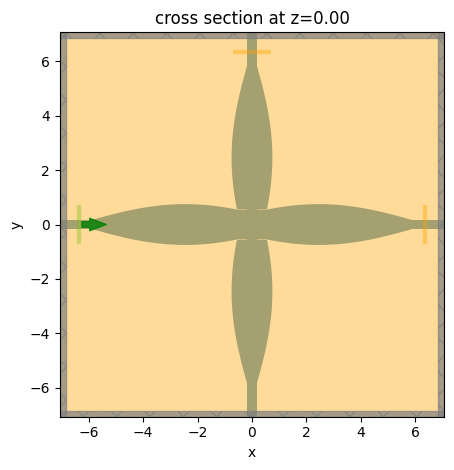

In [5]:
lda0 = 1.31  # central wavelength
freq0 = td.C_0 / lda0  # operation frequency
ldas = np.linspace(1.26, 1.36, 101)  # wavelength range of interest
freqs = td.C_0 / ldas  # frequency range of interest

l_wg = 1  # input/output waveguide length
Lx = 2 * l_t + w_out + 2 * l_wg
Ly = 2 * l_t + w_out + 2 * l_wg
Lz = 1.5 * lda0
sim_size = (Lx, Ly, Lz)

# define a mode source for excitation using the lowest order mode
mode_source = td.ModeSource(
    center=(-Lx / 2 + l_wg / 2, 0, 0),
    size=(0, 4 * w_in, 4 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=3.455, filter_pol="te"),
    mode_index=0,
)

# add a field monitor at z=0 for field visualization
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# define a flux monitor to detect transmission to the through port
flux_monitor_through = td.FluxMonitor(
    center=(Lx / 2 - l_wg / 2, 0, 0),
    size=(0, 4 * w_in, 4 * h),
    freqs=freqs,
    name="flux_through",
)

# define a flux monitor to detect transmission to the cross port
flux_monitor_cross = td.FluxMonitor(
    center=(0, Ly / 2 - l_wg / 2, 0),
    size=(4 * w_in, 0, 4 * h),
    freqs=freqs,
    name="flux_cross",
)

sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[taper_1, taper_2, taper_3, taper_4, center, horizontal_wg, vertical_wg],
    sources=[mode_source],
    monitors=[field_monitor, flux_monitor_through, flux_monitor_cross],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

sim.plot(z=0)
plt.show()


Once the simulation set up is verified, submit job to the server.

In [6]:
job = web.Job(simulation=sim, task_name="waveguide_crossing", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


[17:41:47] Created task 'waveguide_crossing' with task_id                                             ]8;id=420197;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=375833;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\
           'fdve-30806f5b-f3c7-4f80-921f-220960aadd45v1'.                                                          

           View task using web UI at                                                                  ]8;id=842103;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=69369;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=166274;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30806f5b-f3c7-4f80-921f-220960aadd45v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=167047;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30806f5b-f3c7-4f80-921f-220960aadd45v1\taskId]8;;\]8;id=166274;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30806f5b-f3c7-4f80-921f-220960aadd45v1\=]8;;\]8;id=301740;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30806f5b-f3c7-4f80-921f-220960aadd45v1\fdve]8;;\]8;id=166274;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30806f5b-f3c7-4f80-921f-220960aadd45v1\-30806f5b-f3c7-4f80-921f-220960aadd4]8;;\              
           ]8;id=166274;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30806f5b-f3c7-4f80-921f-220960aadd45v1\5v1']8;;\.                                                                                                   

Output()

[17:41:53] status = queued                                                                            ]8;id=867661;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=14928;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#321\321]8;;\

Output()

[17:42:23] status = preprocess                                                                        ]8;id=872270;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=150353;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#315\315]8;;\

[17:42:30] Maximum FlexCredit cost: 0.488. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=638671;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=494398;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=264853;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=129203;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=51620;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=926302;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#352\352]8;;\

Output()

[17:45:52] early shutoff detected, exiting.                                                           ]8;id=485164;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=442526;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=251166;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=230829;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#383\383]8;;\

Output()

[17:46:05] status = success                                                                           ]8;id=72690;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=674819;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#390\390]8;;\

Output()

[17:46:06] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=248347;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=159576;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

## Result Visualization 

After the simulation is complete, first plot the field intensity distribution. 

From the figure below, a good transmission to the through port is observed. In the crossing junction, a strong field focus is formed due to the focusing property of the cosine taper. 

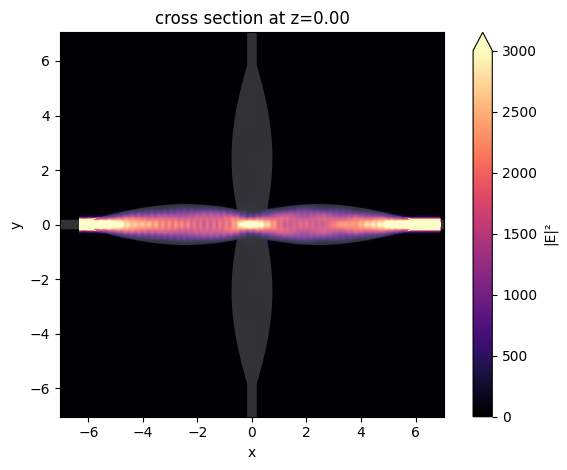

In [7]:
sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", f=freq0, vmin=0, vmax=3000
)
plt.show()


Finally, to quantify the designed waveguide crossing's performance, plot insertion loss and crosstalk level.

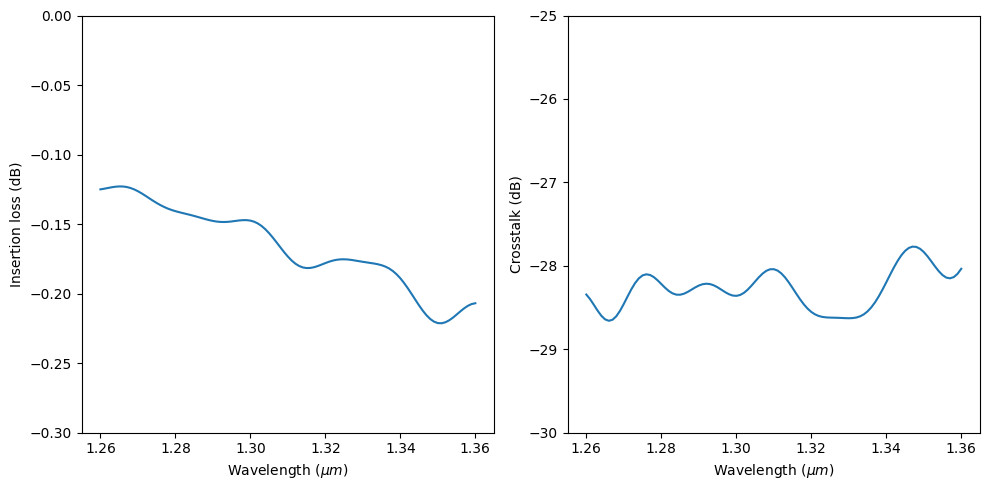

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))

T_through = sim_data["flux_through"].flux
T_cross = sim_data["flux_cross"].flux

ax1.plot(ldas, 10 * np.log10(T_through))
ax1.set_xlabel("Wavelength ($\mu m$)")
ax1.set_ylabel("Insertion loss (dB)")
ax1.set_ylim((-0.3, 0))

ax2.plot(ldas, 10 * np.log10(T_cross))
ax2.set_xlabel("Wavelength ($\mu m$)")
ax2.set_ylabel("Crosstalk (dB)")
ax2.set_ylim((-30, -25))
plt.show()
